# Custom Chatbot: 2024 Events in Spain

TODO: In this cell, write an explanation of which dataset you have chosen and why it is appropriate for this task

In [133]:
import os
from dotenv import load_dotenv
import openai

In [99]:
load_dotenv(".env")

True

In [105]:
openai_client = openai.OpenAI(
  api_key=os.environ['OPENAI_API_KEY'],
)

## Data Wrangling

TODO: In the cells below, load your chosen dataset into a `pandas` dataframe with a column named `"text"`. This column should contain all of your text data, separated into at least 20 rows.

### Get the Data

In [134]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin
from datetime import datetime
from typing import Optional

In [135]:
def get_wikipedia_events(url: str) -> list[dict]:
    """
    Scrape events from a Wikipedia year-in-country page.
    
    Unfortunately, this scrapping function needs to be implemented ad-hoc
    for each use case.
    
    Args:
        url (str): URL of the Wikipedia page to scrape.
    
    Returns:
        list[dict]: A list of dictionaries, each containing details about an event:
            - month (str): The month of the event.
            - date_text (str): The raw date text from the page.
            - date (datetime.date): The parsed start date of the event.
            - date_end (Optional[datetime.date]): The parsed end date if it's a date range, else None.
            - event (str): The cleaned event description.
            - refs (list[str]): List of reference IDs from the page.
            - reference_urls (list[str]): List of URLs for references.
            - reference_entities (list[str]): List of entities associated with the references.
    """
    BASE_URL = "https://en.wikipedia.org"
    HEADERS = {"User-Agent": "Mozilla/5.0"}

    def _clean_event_text(text: str) -> str:
        """Normalize dashes, remove references like [2], and trim."""
        # Normalize en dash/em dash to plain ASCII hyphen
        text = text.replace("\u2013", "-").replace("\u2014", "-")

        # Remove [x] reference markers
        import re
        text = re.sub(r"\[\s*\d+\s*\]", "", text)
        return text.strip()

    def _parse_dates(date_str: str, year: int = 2024) -> tuple[datetime.date, Optional[datetime.date]]:
        """Parse single or span dates into datetime objects."""
        date_str = date_str.strip()
        # Normalize dashes
        date_str = date_str.replace("\u2013", "-").replace("\u2014", "-")

        if "-" in date_str:  # Handle spans like "30 January-3 February"
            start_str, end_str = [s.strip() for s in date_str.split("-", 1)]
            try:
                start_date = datetime.strptime(f"{start_str} {year}", "%d %B %Y").date()
            except ValueError:
                start_date = None
            try:
                end_date = datetime.strptime(f"{end_str} {year}", "%d %B %Y").date()
            except ValueError:
                end_date = None
            return start_date, end_date
        else:
            try:
                start_date = datetime.strptime(f"{date_str} {year}", "%d %B %Y").date()
            except ValueError:
                start_date = None
            return start_date, None

    response = requests.get(url, headers=HEADERS)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")

    events = []
    events_div = soup.find("h2", id="Events").parent
    sibling = events_div.find_next_sibling()

    while sibling and not (sibling.name == "div" and sibling.find("h2")):
        if sibling.name == "div" and sibling.find("h3"):  # month header
            month = sibling.get_text(strip=True).replace("[edit]", "")
        elif sibling.name == "ul":
            for li in sibling.find_all("li", recursive=False):
                text_raw = li.get_text(" ", strip=True)
                text_clean = _clean_event_text(text_raw)

                # Split into date + event
                if " - " in text_clean:
                    date_text, event_text = text_clean.split(" - ", 1)
                else:
                    date_text, event_text = None, text_clean

                # Parse dates
                date, date_end = _parse_dates(date_text or "", year=2024)

                refs = [a["href"][1:] for a in li.select("sup.reference a[href^='#cite_note']")]
                reference_urls, reference_entities = [], []

                # External reference section
                for ref in refs:
                    ref_li = soup.find("li", id=ref)
                    if ref_li:
                        link = ref_li.find("a", class_="external text")
                        if link:
                            url_ref = link["href"]
                            reference_urls.append(url_ref)
                            reference_entities.append(urlparse(url_ref).netloc.replace("www.", ""))

                # Fallback: inline links
                if not reference_urls:
                    for a in li.find_all("a", href=True):
                        href = a["href"]
                        if href.startswith("/wiki/"):
                            url_ref = urljoin(BASE_URL, href)
                            reference_urls.append(url_ref)
                            reference_entities.append("Wikipedia")

                events.append({
                    "month": month,
                    "date_text": date_text,
                    "date": date,
                    "date_end": date_end,
                    "event": event_text,
                    "refs": refs,
                    "reference_urls": reference_urls,
                    "reference_entities": reference_entities
                })
        sibling = sibling.find_next_sibling()

    return events


In [74]:
# Get events
URL = "https://en.wikipedia.org/wiki/2024_in_Spain"
events = get_wikipedia_events(URL)

print(f"Total events found: {len(events)}")
for e in events[:10]:
    print(e)

Total events found: 54
{'month': 'January', 'date_text': '30 January-3 February', 'date': datetime.date(2024, 1, 30), 'date_end': datetime.date(2024, 2, 3), 'event': 'Benidorm Fest 2024 (1st semifinal)', 'refs': ['cite_note-2', 'cite_note-3'], 'reference_urls': ['https://www.formulatv.com/noticias/fechas-benidorm-fest-2024-semifinales-final-123651/', 'https://www.escplus.es/eurovision/2023/los-candidatos-del-benidorm-fest-2024-se-presentaran-en-el-teatro-alameda-a-las-1830-el-proximo-11-de-noviembre/'], 'reference_entities': ['formulatv.com', 'escplus.es']}
{'month': 'February', 'date_text': '3 February', 'date': datetime.date(2024, 2, 3), 'date_end': None, 'event': '16th Gaudí Awards in Barcelona , Catalonia', 'refs': ['cite_note-4'], 'reference_urls': ['https://www.lavanguardia.com/vida/20230711/9102019/premios-gaudi-2024-otorgaran-3-febrero-teniendo-cuenta-codigo-conducta.html'], 'reference_entities': ['lavanguardia.com']}
{'month': 'February', 'date_text': '9 February', 'date': dat

### Extend the Data with Referenced Content

In [136]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

In [180]:
def get_event_reference_contents(
    events: list[dict],
    max_chars: int = 1000,
    timeout: int = 10,
) -> list[dict]:
    """
    Fetches reference content for each event and adds it as a new field.
    
    Args:
        events (list[dict]): List of event dictionaries.
        max_chars (int): Max number of characters to keep from scraped text.
        timeout (int): Timeout for HTTP requests.
    
    Returns:
        list[dict]: Enriched events with 'reference_content' field.
    """
    HEADERS = {"User-Agent": "Mozilla/5.0"}
    for e in tqdm(events):
        reference_content = []
        for url in e.get("reference_urls", []):
            try:
                resp = requests.get(url, headers=HEADERS, timeout=timeout)
                resp.raise_for_status()
                soup = BeautifulSoup(resp.text, "html.parser")

                # Grab visible text (first few paragraphs)
                paragraphs = soup.find_all("p")
                text = " ".join(p.get_text(" ", strip=True) for p in paragraphs)
                text = text.replace("\n", " ").strip()

                # Truncate long text
                if len(text) > max_chars:
                    text = text[:max_chars] + "..."

                reference_content.append(text)

            except Exception as ex:
                reference_content.append(None)

        # Join contents if multiple refs
        e["reference_content"] = reference_content
    
        # Assemble a single text field for the event    
        text = f"Date: {e['date_text']}. Event: {e['event']}."
        if reference_content:
            ref_texts_valid = [str(rc) for rc in reference_content if rc]
            text += f" Event context: {'. '.join(ref_texts_valid)}"
        e["text"] = text
    
    return events


In [181]:
# Extend event context
events_extended = get_event_reference_contents(events)

  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [01:36<00:00,  1.79s/it]


In [182]:
events_extended[0]

{'month': 'January',
 'date_text': '30 January-3 February',
 'date': datetime.date(2024, 1, 30),
 'date_end': datetime.date(2024, 2, 3),
 'event': 'Benidorm Fest 2024 (1st semifinal)',
 'refs': ['cite_note-2', 'cite_note-3'],
 'reference_urls': ['https://www.formulatv.com/noticias/fechas-benidorm-fest-2024-semifinales-final-123651/',
  'https://www.escplus.es/eurovision/2023/los-candidatos-del-benidorm-fest-2024-se-presentaran-en-el-teatro-alameda-a-las-1830-el-proximo-11-de-noviembre/'],
 'reference_entities': ['formulatv.com', 'escplus.es'],
 'reference_content': ["CALENDARIO Así lo ha confirmado la organización en la rueda de prensa celebrada en Benidorm. Programa relacionado Benidorm Fest 2022 - Act España Concursos Entretenimiento Popularidad: #78 de 2.153 Vídeos FormulaTV 'Traitors: El debate' Programa 2 Tu Cara Me Suena El Debate! Analizamos la gala 6 Nos colamos en la grabación de Cifras y Letras Tu Cara Me Suena El Debate! Analizamos la gala 2 María Bernardeau y Biel Anton nos

### Persist the Data as JSONL

In [183]:
import json
from datetime import datetime, date

def save_events_to_jsonl(events, path="events.jsonl") -> None:
    with open(path, "w", encoding="utf-8") as f:
        for event in events:
            event_copy = event.copy()
            # Convert dates to ISO string
            for k in ["date", "date_end"]:
                if isinstance(event_copy.get(k), (datetime, date)):
                    event_copy[k] = event_copy[k].isoformat()
            f.write(json.dumps(event_copy, ensure_ascii=False) + "\n")


def load_events_from_jsonl(path="events.jsonl") -> list[dict]:
    events = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            # Parse back dates
            for k in ["date", "date_end"]:
                if obj.get(k):
                    try:
                        obj[k] = datetime.fromisoformat(obj[k]).date()
                    except Exception:
                        pass
            events.append(obj)
    return events


In [184]:
# Save events to file
save_events_to_jsonl(events_extended, path="data/events_spain_2024.jsonl")

In [185]:
events_dicts = load_events_from_jsonl(path="data/events_spain_2024.jsonl")

In [186]:
events_dicts[0]

{'month': 'January',
 'date_text': '30 January-3 February',
 'date': datetime.date(2024, 1, 30),
 'date_end': datetime.date(2024, 2, 3),
 'event': 'Benidorm Fest 2024 (1st semifinal)',
 'refs': ['cite_note-2', 'cite_note-3'],
 'reference_urls': ['https://www.formulatv.com/noticias/fechas-benidorm-fest-2024-semifinales-final-123651/',
  'https://www.escplus.es/eurovision/2023/los-candidatos-del-benidorm-fest-2024-se-presentaran-en-el-teatro-alameda-a-las-1830-el-proximo-11-de-noviembre/'],
 'reference_entities': ['formulatv.com', 'escplus.es'],
 'reference_content': ["CALENDARIO Así lo ha confirmado la organización en la rueda de prensa celebrada en Benidorm. Programa relacionado Benidorm Fest 2022 - Act España Concursos Entretenimiento Popularidad: #78 de 2.153 Vídeos FormulaTV 'Traitors: El debate' Programa 2 Tu Cara Me Suena El Debate! Analizamos la gala 6 Nos colamos en la grabación de Cifras y Letras Tu Cara Me Suena El Debate! Analizamos la gala 2 María Bernardeau y Biel Anton nos

### Create the Dataframe with the Embeddings

In [187]:
import pandas as pd
import numpy as np
import ast

In [188]:
import pandas as pd
from openai import OpenAI
from typing import Union

def compute_embeddings(
    texts: Union[str, list[str]],
    openai_client: OpenAI,
    embeddings_model_name: str = "text-embedding-ada-002"
) -> list[list[float]]:
    """
    Compute embeddings for a single string or a list of strings using OpenAI.
    
    Args:
        texts: A string or list of strings to embed.
        openai_client: An OpenAI client instance.
        embeddings_model_name: Model name for embeddings.
    
    Returns:
        List of embeddings (one per input string).
    """
    if isinstance(texts, str):
        texts = [texts]

    response = openai_client.embeddings.create(
        model=embeddings_model_name,
        input=texts
    )

    return [item.embedding for item in response.data]


def compute_embeddings_from_df(
    df: pd.DataFrame,
    openai_client: OpenAI,
    embeddings_model_name: str = "text-embedding-ada-002",
    text_column: str = "text",
    batch_size: int = 100
) -> list[list[float]]:
    """
    Compute embeddings for a dataframe column of text using OpenAI, in batches.
    
    Args:
        df: DataFrame containing text data.
        openai_client: OpenAI client instance.
        embeddings_model_name: Model name for embeddings.
        text_column: Name of the column with text data.
        batch_size: Number of rows per batch for embedding computation.
    
    Returns:
        List of embeddings corresponding to each row in the DataFrame.
    """
    embeddings = []
    for i in range(0, len(df), batch_size):
        batch_texts = df.iloc[i:i + batch_size][text_column].tolist()
        batch_embeddings = compute_embeddings(batch_texts, openai_client, embeddings_model_name)
        embeddings.extend(batch_embeddings)

    return embeddings

In [ ]:
def create_dataframe_from_events(
    events: list[dict],
    openai_client: openai.OpenAI,
) -> pd.DataFrame:
    """
    Create a DataFrame from events with columns:
      - date
      - event
      - text
    And compute embeddings for the `text` column.
    """
    # Build rows
    rows = []
    for e in events:
        rows.append({
            "date": e.get("date"),
            "event": e.get("event", ""),
            "text": e.get("text", "")
        })

    # Create DataFrame
    df = pd.DataFrame(rows)

    # Compute embeddings
    df["embeddings"] = compute_embeddings_from_df(df, openai_client)

    return df


In [190]:
# Create the dataframe with embeddings
events_df = create_dataframe_from_events(events_dicts, openai_client)

In [191]:
events_df.head()

,date,event,text,embeddings
0,2024-01-30,Benidorm Fest 2024 (1st semifinal),Date: 30 January-3 February. Event: Benidorm F...,"[-0.01977549120783806, -0.025000454857945442, ..."
1,2024-02-03,"16th Gaudí Awards in Barcelona , Catalonia",Date: 3 February. Event: 16th Gaudí Awards in ...,"[-0.011208840645849705, 0.006803915370255709, ..."
2,2024-02-09,Two police officers are killed and two more ar...,Date: 9 February. Event: Two police officers a...,"[-0.012224542908370495, -0.00614622887223959, ..."
3,2024-02-10,"38th Goya Awards in Valladolid , Castile and León",Date: 10 February. Event: 38th Goya Awards in ...,"[-0.020344838500022888, -0.020213834941387177,..."
4,2024-02-18,2024 Galician regional election,Date: 18 February. Event: 2024 Galician region...,"[-0.015883542597293854, -0.0005480649415403605..."


In [192]:
# Dimensionality of the embeddings: 1536
print(len(events_df.loc[0, "embeddings"]))

1536


In [193]:
# Save to CSV
events_df.to_csv("data/events_spain_2024_embeddings.csv")

In [194]:
# Load from CSV
events_df = pd.read_csv("data/events_spain_2024_embeddings.csv", index_col=0)
events_df["embeddings"] = events_df["embeddings"].apply(ast.literal_eval)

In [195]:
events_df.head()

,date,event,text,embeddings
0,2024-01-30,Benidorm Fest 2024 (1st semifinal),Date: 30 January-3 February. Event: Benidorm F...,"[-0.01977549120783806, -0.025000454857945442, ..."
1,2024-02-03,"16th Gaudí Awards in Barcelona , Catalonia",Date: 3 February. Event: 16th Gaudí Awards in ...,"[-0.011208840645849705, 0.006803915370255709, ..."
2,2024-02-09,Two police officers are killed and two more ar...,Date: 9 February. Event: Two police officers a...,"[-0.012224542908370495, -0.00614622887223959, ..."
3,2024-02-10,"38th Goya Awards in Valladolid , Castile and León",Date: 10 February. Event: 38th Goya Awards in ...,"[-0.020344838500022888, -0.020213834941387177,..."
4,2024-02-18,2024 Galician regional election,Date: 18 February. Event: 2024 Galician region...,"[-0.015883542597293854, -0.0005480649415403605..."


## Relevant Data Retrieval

In [199]:
from scipy.spatial.distance import cosine as cosine_distance
from scipy.spatial.distance import cdist

In [202]:
embeddings_matrix = np.stack(events_df["embeddings"].to_numpy())

In [245]:
def sort_docs_by_relevance(
    question: str,
    embeddings_matrix: np.ndarray,
    openai_client: OpenAI,
    distance_metric: str = "cosine",
) -> tuple[np.ndarray, np.ndarray]:
    """
    Given a question and a matrix of embeddings, return the indices of the most
    relevant documents and their distances.

    Args:
        question: The query string.
        embeddings_matrix: np.ndarray of shape (n_docs, embedding_dim).
        openai_client: Initialized OpenAI client.
        distance_metric: Metric to compute similarity ("cosine", etc.).

    Returns:
        sorted_doc_ids: np.ndarray of row indices sorted by relevance (ascending distance).
        sorted_doc_distances: np.ndarray of distances sorted in the same order.
    """
    # Get embedding for the query
    question_embedding = compute_embeddings(question, openai_client)

    # Compute distances
    distances = cdist(question_embedding, embeddings_matrix, metric=distance_metric)[0]

    # Sort by ascending distance
    sorted_doc_ids = np.argsort(distances)
    sorted_doc_distances = distances[sorted_doc_ids]

    return sorted_doc_ids, sorted_doc_distances

In [251]:
sorted_doc_ids, sorted_doc_distances = sort_docs_by_relevance(
    "When was the first election in Spain in the year 2024 and where was it?",
    embeddings_matrix,
    openai_client,
)

In [252]:
sorted_doc_ids

array([ 4,  8, 22, 11,  7, 20, 32,  9, 10, 37, 12, 44, 52,  3, 41,  1, 46,
       33, 18, 35, 25, 30, 29,  0, 26, 39, 31, 40, 45,  5,  6, 17, 19, 16,
       36, 23, 34, 14, 13, 21, 48, 38, 47, 49, 15,  2, 42, 28, 50, 43, 27,
       24, 53, 51])

In [253]:
events_df.iloc[sorted_doc_ids[:3]]  # Top 3 most relevant events

,date,event,text,embeddings
4,2024-02-18,2024 Galician regional election,Date: 18 February. Event: 2024 Galician region...,"[-0.015883542597293854, -0.0005480649415403605..."
8,2024-04-21,2024 Basque regional election,Date: 21 April. Event: 2024 Basque regional el...,"[-0.007071869447827339, -0.017295772209763527,..."
22,2024-06-11,2024 Spain floods .,Date: 11 June. Event: 2024 Spain floods .. Eve...,"[-0.01786954142153263, -0.023753413930535316, ..."


In [254]:
import matplotlib.pyplot as plt

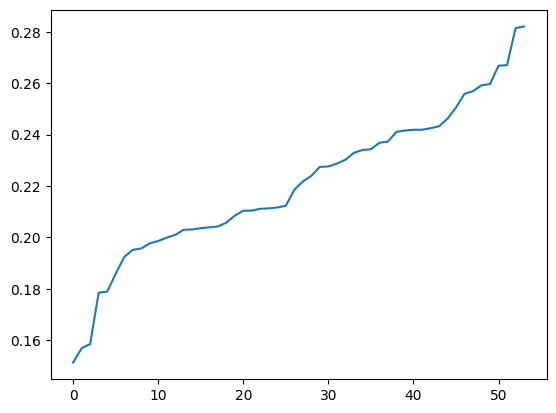

In [255]:
plt.plot(sorted_doc_distances)

## Custom Query Completion

TODO: In the cells below, compose a custom query using your chosen dataset and retrieve results from an OpenAI `Completion` model. You may copy and paste any useful code from the course materials.

### Query Prompt

In [256]:
import tiktoken

def create_prompt(
    question: str,
    events_dicts: list[dict],
    sorted_doc_ids: np.ndarray,
    sorted_doc_distances: np.ndarray,
    max_token_count: int
) -> tuple[str, list[int], list[float]]:
    """
    Given a question and a dataframe containing rows of text and their
    embeddings, return a text prompt to send to a Completion model
    """
    # Create a tokenizer that is designed to align with our embeddings
    # Tiktoken is the official tokenizer for OpenAI models
    # GPT-4, GPT-3.5, text-embedding-ada-002 use the same tokenizer: cl100k_base
    tokenizer = tiktoken.get_encoding("cl100k_base")
    
    # Count the number of tokens in the prompt template and question
    prompt_template = """
Answer the question based on the context below, and if the question
can't be answered based on the context, say "I don't know"

Context: 

{}

---

Question: {}
Answer:"""
    
    current_token_count = len(tokenizer.encode(prompt_template)) + \
                            len(tokenizer.encode(question))
    
    context = []
    selected_doc_ids = []
    selected_doc_distances = []
    for doc_id, distance in zip(sorted_doc_ids, sorted_doc_distances):
        # Increase the counter based on the number of tokens in this row
        text = events_dicts[doc_id]["text"]
        text_token_count = len(tokenizer.encode(text))
        current_token_count += text_token_count
        # Add the row of text to the list if we haven't exceeded the max
        if current_token_count <= max_token_count:
            context.append(text)
            selected_doc_ids.append(int(doc_id))
            selected_doc_distances.append(float(distance))
        else:
            break

    return prompt_template.format("\n\n###\n\n".join(context), question), selected_doc_ids, selected_doc_distances

In [257]:
# Retrieve sorted relevant doc ids
question="When was the first election in Spain in the year 2024 and where was it?"
sorted_doc_ids, sorted_doc_distances = sort_docs_by_relevance(question, embeddings_matrix, openai_client)

# Create prompt
prompt, selected_doc_ids, selected_doc_distances = create_prompt(
    question,
    events_dicts,
    sorted_doc_ids,
    sorted_doc_distances,
    max_token_count=1000,
)

In [258]:
print(prompt)


Answer the question based on the context below, and if the question
can't be answered based on the context, say "I don't know"

Context: 

Date: 18 February. Event: 2024 Galician regional election. Event context: Alfonso Rueda PP Alfonso Rueda PP A regional election was held in Galicia on Sunday, 18 February 2024, to elect the 12th Parliament of the autonomous community . All 75 seats in the Parliament were up for election. The Parliament of Galicia was the devolved , unicameral legislature of the autonomous community of Galicia , having legislative power in regional matters as defined by the Spanish Constitution and the Galician Statute of Autonomy , as well as the ability to vote confidence in or withdraw it from a regional president . [ 1 ] Voting for the Parliament was on the basis of universal suffrage , which comprised all nationals over 18 years of age, registered in Galicia and in full enjoyment of their political rights. Amendments to the electoral law in 2022 abolished the "

In [259]:
print("Relevant document IDs:", selected_doc_ids)
print("Distances:", selected_doc_distances)

Relevant document IDs: [4, 8, 22, 11, 7]
Distances: [0.15128738717301804, 0.15683151685470642, 0.15847661510110922, 0.1784375407220119, 0.17887305108509066]


### Query Answering Function

## Custom Performance Demonstration

TODO: In the cells below, demonstrate the performance of your custom query using at least 2 questions. For each question, show the answer from a basic `Completion` model query as well as the answer from your custom query.

### Question 1

### Question 2